In [ ]:
import torch
import torchvision
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import tqdm
import torch.nn.functional as F
from google.colab import drive 



In [ ]:
# Read data

drive.mount('/content/gdrive', force_remount=True)
train = pd.read_csv("/content/gdrive/MyDrive/Y2S2/SP3172/Hot_encoded_and_feature_scaled/correct_train.csv", encoding= 'ISO-8859-1', low_memory = False)
test = pd.read_csv("/content/gdrive/MyDrive/Y2S2/SP3172/Hot_encoded_and_feature_scaled/correct_test.csv", encoding= 'ISO-8859-1', low_memory = False)
val = pd.read_csv("/content/gdrive/MyDrive/Y2S2/SP3172/Hot_encoded_and_feature_scaled/correct_val.csv", encoding= 'ISO-8859-1', low_memory = False)

Mounted at /content/gdrive


In [ ]:
# Read a subset of data

test_ = test.iloc[:, :]
train_ = train.iloc[:, :]
val_ = val.iloc[:, :]
size = (train_.shape[1])
size

1406283

In [ ]:
# Make the class so that the data could be loaded into DataLoader()

class MyDataset():

  def __init__(self,file_name):
    df=file_name

    x=df.iloc[:,2:].values
    y=df.iloc[:,:2].values
    #print(y)
    self.x_train=torch.tensor(x,dtype=torch.float32)
    self.y_train=torch.tensor(y,dtype=torch.float32)

  def __len__(self):
    return len(self.y_train)
  
  def __getitem__(self,idx):
    return self.x_train[idx],self.y_train[idx]

train_ = MyDataset(train_)
test_ = MyDataset(test_)
val_ = MyDataset(val_)

In [ ]:
# Model Building

# Input --> Hidden dim --> mean, std --> Parametrization trick --> Decoder --> Output
# input_dim: e.g. it will be 784 if your input is a tensor of 28x28
# h_dim: dim of hidden layers
# with batch normalisation + variational dropout

import torch.nn.functional as F


class VAE(nn.Module):
    def __init__(self, input_dim, h_dim=1000, z_dim=10, dropout_rate=0.5):
        super().__init__()
        
        # Encoder
        # In the KL Divegence, hid22mu & hid22sigma will be pushed to learn the standard Gaussian
        self.input2hid1 = nn.Linear(input_dim, h_dim)
        self.hid12hid2 = nn.Linear(h_dim, h_dim)
        self.hid22mu = nn.Linear(h_dim, z_dim)
        self.hid22sigma = nn.Linear(h_dim, z_dim)
        
        # Decoder
        self.z2hid1 = nn.Linear(z_dim, h_dim)
        self.hid12hid2d = nn.Linear(h_dim, h_dim)
        self.hid22output = nn.Linear(h_dim, input_dim)
        
        self.bn1 = nn.BatchNorm1d(h_dim)
        self.bn2 = nn.BatchNorm1d(h_dim)
        self.bn3 = nn.BatchNorm1d(h_dim)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.leakyrelu = nn.LeakyReLU()
        self.dropout_rate = dropout_rate
        
        
    def encode(self, x):
        # q_phi(z|x)
        
        hidden = self.leakyrelu(self.bn1(self.input2hid1(x)))
        hidden = self.relu(hidden)
        hidden = self.leakyrelu(self.bn2(self.hid12hid2(hidden)))
        mu, sigma = self.hid22mu(hidden), self.hid22sigma(hidden)
        return mu, sigma
        
        
    def decode(self, z):
        # p_theta(x|z)
        
        hidden = self.leakyrelu(self.bn3(self.z2hid1(z)))
        hidden = self.relu(hidden)
        hidden = F.dropout(self.leakyrelu(self.hid12hid2d(hidden)), p=self.dropout_rate, training=self.training)
        output = self.sigmoid(self.hid22output(hidden))
        return output
        
        
    def forward(self, x):
        mu, sigma = self.encode(x)
        eps = torch.randn_like(sigma)
        z_reparametrized = mu + sigma*eps
        x_reconstruct = self.decode(z_reparametrized)
        return x_reconstruct, mu, sigma


In [ ]:
# Configuration

# DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE = torch.device("cpu")
INPUT_DIM = size-2
H_DIM = 1000  
Z_DIM = 10
NUM_EPOCHS = 50
BATCH_SIZE = 61 #result.x[1]  #33
LR_RATE = 0.000849 #result.x[0]  #3e-4

In [ ]:
# Visualisation of model architecture

!pip install torchviz
from torchviz import make_dot

x = torch.zeros(BATCH_SIZE, INPUT_DIM).to(DEVICE)
model = VAE(INPUT_DIM, H_DIM, Z_DIM).to(DEVICE)
y, _, _ = model(x)
make_dot(y, params=dict(model.named_parameters())).render("vae_graph", format="png")




Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4147 sha256=ae408beb0ad4f5222061df1f6f5e4e3a297185ef41846608f395f27e39a5529a
  Stored in directory: /root/.cache/pip/wheels/29/65/6e/db2515eb1dc760fecd36b40d54df65c1e18534013f1c037e2e
Successfully built torchviz


'vae_graph.png'

In [ ]:
# Model summary

from torchsummary import summary

model = VAE(input_dim=INPUT_DIM, h_dim=1000, z_dim=10, dropout_rate=0.5)
summary(model, (INPUT_DIM,))




RuntimeError: ignored

In [ ]:
# Dataset Loading

from torch.utils.data.dataset import random_split

#train, test, val = random_split(data, [0.9, 0.05, 0.05], generator=torch.Generator().manual_seed(42))
train_loader = DataLoader(dataset = train_, batch_size = BATCH_SIZE, shuffle = True)
test_loader = DataLoader(dataset = test_, batch_size = BATCH_SIZE, shuffle = False)
val_loader = DataLoader(dataset = val_, batch_size = BATCH_SIZE, shuffle = False)
model = VAE(INPUT_DIM, H_DIM, Z_DIM, dropout_rate=0.5).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr = LR_RATE)
dataloaders = {
    "train": train_loader,
    "validation": val_loader
}
loss_fn = nn.MSELoss(reduction = "sum") 



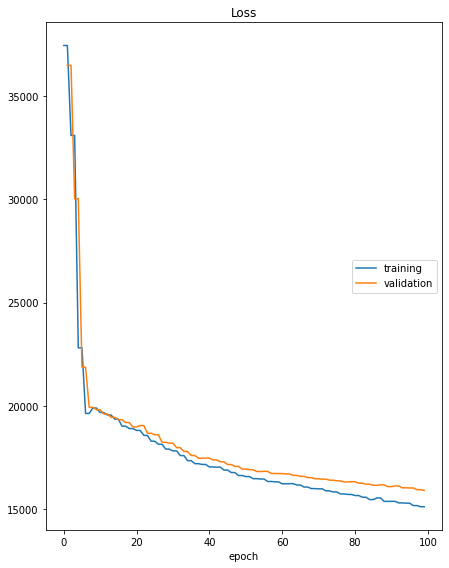

Loss
	training         	 (min: 15117.691, max: 37456.617, cur: 15117.691)
	validation       	 (min: 15907.560, max: 36494.223, cur: 15907.560)


In [ ]:
#!pip install livelossplot
from livelossplot import PlotLosses
lambda1 = 0.000774
lambda2 = 0.000528

liveloss = PlotLosses()

def anneal_function(epoch, T=50):
    return (1 + np.cos(np.pi * epoch / T)) / 2

beta_max = 1  # Maximum beta value
beta_min = 0.1  # Minimum beta value
T = 10  # Annealing period (in epochs)

model = VAE(INPUT_DIM, H_DIM, Z_DIM).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LR_RATE)
logs = {}
best_val_loss = float('inf')
for epoch in range(NUM_EPOCHS):
    loss_lst = []
    for phase in ["train", "validation"]:
        if phase == "train":
            model.train()
        else:
            model.eval()
        loop = tqdm.tqdm(enumerate(dataloaders[phase]))
        for i, (x, _) in loop:
            # Forward pass
            x = x.to(DEVICE).view(x.shape[0], -1)
            x_reconstruct, mu, sigma = model(x)

            # Compute loss with Loss function
            anneal = anneal_function(epoch % T, T)
            beta = beta_min + (beta_max - beta_min) * anneal

            # Compute loss with Loss function and add Elastic Net regularization terms
            reconstruction_loss = loss_fn(x_reconstruct, x)/len(x)
            kl_div = (-0.5 * torch.sum(1 + torch.log(sigma.pow(2)) - mu.pow(2) - sigma.pow(2)*beta))/len(x)
            # Compute L1 regularization
            L1_regularization = torch.tensor(0., device=DEVICE)
            for param in model.parameters():
                L1_regularization += torch.norm(param, 1)
    
            L2_regularization = torch.tensor(0., device=DEVICE)
            for param in model.parameters():
                L2_regularization += torch.norm(param, 2)
    

            loss = reconstruction_loss + kl_div + (lambda1 * L1_regularization)/len(x) + (lambda2 * L2_regularization)/len(x)
            loss_lst.append(loss.item())

            if phase == "train":
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            loop.set_postfix(loss=loss.item())

        prefix = ""
        if phase == "validation":
            prefix = "val_"

        logs[prefix + "loss"] = np.mean(loss_lst)

        liveloss.update(logs)
    liveloss.send()
    # Find the epoch with the lowest validation loss

    if logs["val_loss"] < best_val_loss:
        min_val_loss_epoch = epoch
        best_val_loss = logs["val_loss"]

# Get the beta value used for that epoch
best_beta = beta_min + (beta_max - beta_min) * anneal_function(min_val_loss_epoch % T, T)

# Evaluate the model with the best beta value
model.eval()
loss_lst = []
for i, (x, _) in enumerate(test_loader):
    x = x.to(DEVICE).view(x.shape[0], -1)
    x_reconstruct, mu, sigma = model(x)

    # Compute loss with Loss function
    beta = best_beta

    reconstruction_loss = loss_fn(x_reconstruct, x)/len(x)
    kl_div = (-0.5 * torch.sum(1 + torch.log(sigma.pow(2)) - mu.pow(2) - sigma.pow(2)*beta))/len(x)
    # Compute L1 regularization
    L1_regularization = torch.tensor(0., device=DEVICE)
    for param in model.parameters():
        L1_regularization += torch.norm(param, 1)
    
    L2_regularization = torch.tensor(0., device=DEVICE)
    for param in model.parameters():
        L2_regularization += torch.norm(param, 2)
    

    loss = reconstruction_loss + kl_div + (lambda1 * L1_regularization)/len(x) + (lambda2 * L2_regularization)/len(x)
    loss_lst.append(loss.item())

mean_loss = np.mean(loss_lst)


In [ ]:
print(best_beta)

0.12202456766718087


# Testing Different Loss Function
- BCE Loss: loss is 7033
- MSE Loss: loss is 2452
- L1 Loss:  loss is 5776
- Cross Entropy Loss: loss is 131918
- Hinge Embedding Loss: 14175  

So MSE Loss is chosen as the loss function

## Below are constants
- INPUT_DIM = 998
- H_DIM = 300
- Z_DIM = 20
- NUM_EPOCHS = 50
- BATCH_SIZE = 32
- LR_RATE = 3e-4 # Karpathy constant

# Bayesian Optimisation
## Optimal Hyperparameters:
- Learning Rate: 0.000552
- Batch Size: 128

In [ ]:
# Read a subset of data
# df_test = df.iloc[:, :]
# size = (df_test.iloc[:, 1:]).shape[1]
# size
test_ = test
train_ = train
val_ = val
size = (train_.shape[1])
size

1406283

In [ ]:
# Configuration

# DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE = torch.device("cpu")
INPUT_DIM = size-2
H_DIM = 1000  
Z_DIM = 10
NUM_EPOCHS = 60
BATCH_SIZE = 78 #result.x[1]  #33
LR_RATE = 0.0006119110453614011 #result.x[0]  #3e-4

In [ ]:
# Dataset Loading

from torch.utils.data.dataset import random_split

# train, test, val = random_split(data, [0.9, 0.05, 0.05], generator=torch.Generator().manual_seed(42))
train_loader = DataLoader(dataset = train_, batch_size = BATCH_SIZE, shuffle = True)
test_loader = DataLoader(dataset = test_, batch_size = BATCH_SIZE, shuffle = False)
val_loader = DataLoader(dataset = val_, batch_size = BATCH_SIZE, shuffle = False)
model = VAE(INPUT_DIM, H_DIM, Z_DIM, dropout_rate=0.5).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr = LR_RATE)
dataloaders = {
    "train": train_loader,
    "validation": val_loader
}
loss_fn = nn.MSELoss(reduction = "sum") 



In [ ]:
{'lr_rate': 0.0006119110453614011, 'batch_size': 78, 'l1': 0.00046893325185287774, 'l2': 0.009564429613490721}

In [ ]:
print(best_beta)

0.12202456766718087


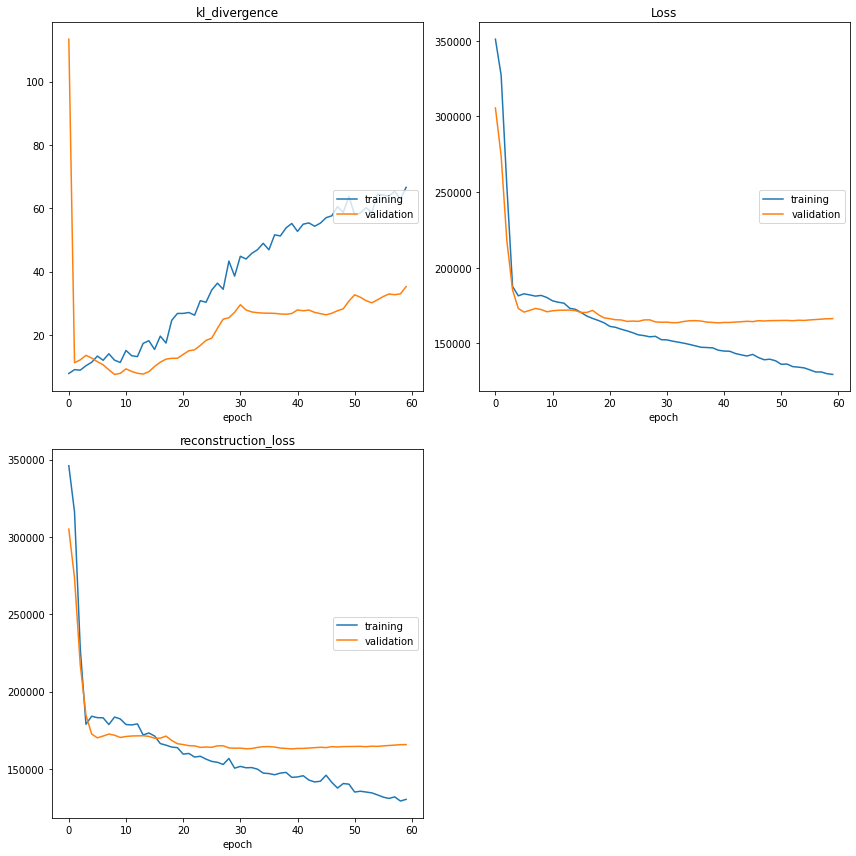

kl_divergence
	training         	 (min:    7.810, max:   66.601, cur:   66.601)
	validation       	 (min:    7.512, max:  113.379, cur:   35.255)
Loss
	training         	 (min: 129527.207, max: 351021.906, cur: 129527.207)
	validation       	 (min: 163584.266, max: 305587.469, cur: 166392.562)
reconstruction_loss
	training         	 (min: 129277.039, max: 346029.531, cur: 130353.336)
	validation       	 (min: 162989.312, max: 305074.750, cur: 165781.203)


In [ ]:
# Model Training with Elastic Net regularization
# Live visualisation of KL divergence & Reconstruction loss
beta = 0.12202456766718087
lambda1 = 0.00046893325185287774
lambda2 = 0.009564429613490721
!pip install livelossplot
from livelossplot import PlotLosses
liveloss = PlotLosses()

x_reconstruct_ls = []
train_loss = []
train_kl = []
val_loss = []
val_kl = []

for epoch in range(NUM_EPOCHS):
    logs = {}
    for phase in ["train", "validation"]:
        kl_lst = []
        loss_lst = []
        if phase == "train":
            model.train()
        else:
            model.eval()
        loop = tqdm.tqdm(enumerate(dataloaders[phase]))
        for i, (x, _) in loop:
          # Forward pass
          #print(len(x))
          x = x.to(DEVICE).view(x.shape[0], -1)
          print(x.shape)
          x_reconstruct, mu, sigma = model(x)

          # Compute loss with Loss function and add Elastic Net regularization terms
          reconstruction_loss = loss_fn(x_reconstruct, x)/len(x)
          kl_div = (-0.5 * torch.sum(1 + torch.log(sigma.pow(2)) - mu.pow(2) - sigma.pow(2)*beta))/len(x)
          # Compute L1 regularization
          L1_regularization = torch.tensor(0., device=DEVICE)
          for param in model.parameters():
              L1_regularization += torch.norm(param, 1)
   
          L2_regularization = torch.tensor(0., device=DEVICE)
          for param in model.parameters():
              L2_regularization += torch.norm(param, 2)
  

          loss = reconstruction_loss + kl_div + (lambda1 * L1_regularization)/len(x) + (lambda2 * L2_regularization)/len(x)
          loss_lst.append(loss.item())
          kl_lst.append(kl_div.item())  # add kl_div to kl_lst here

          if phase == "train":
              optimizer.zero_grad()
              loss.backward()
              optimizer.step()

          loop.set_postfix(loss=loss.item())

        prefix = ""
        if phase == "validation":
          prefix = "val_"

        logs[prefix + "loss"] = np.mean(loss_lst)
        logs[prefix + "reconstruction_loss"] = np.mean(reconstruction_loss.item())
        logs[prefix + "kl_divergence"] = np.mean(kl_div.item())

    # Append the loss and KL divergence values to the lists
    train_loss.append(logs["loss"])
    train_kl.append(logs["kl_divergence"])
    val_loss.append(logs["val_loss"])
    val_kl.append(logs["val_kl_divergence"])

    # Update the live plot with training and validation losses
    liveloss.update({
    'reconstruction_loss': logs.get('reconstruction_loss', 0),
    'val_reconstruction_loss': logs.get('val_reconstruction_loss', 0),
    'kl_divergence': logs.get('kl_divergence', 0),
    'val_kl_divergence': logs.get('val_kl_divergence', 0),
    'loss': logs.get('loss', 0),
    'val_loss': logs.get('val_loss', 0)
    }, epoch)

    # Draw the live plot with training and validation losses
    liveloss.draw()


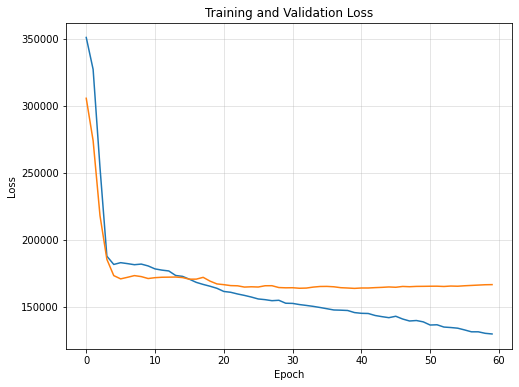

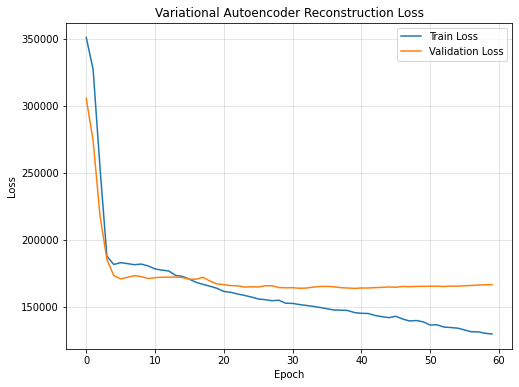

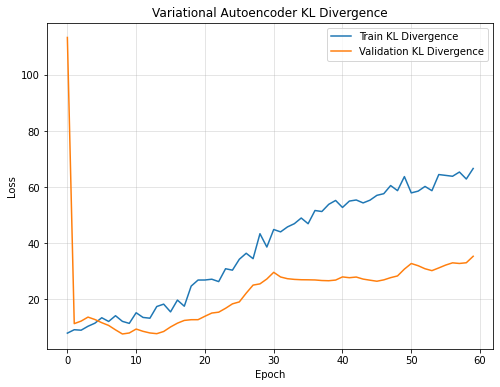

In [ ]:
# Static plot for the loss

import matplotlib.pyplot as plt

# Plot the training and validation losses
plt.figure(figsize=(8, 6))
plt.plot(train_loss, label="Training loss")
plt.plot(val_loss, label="Validation loss")

# Set the plot title, x-label and y-label
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(alpha = 0.4)
plt.savefig("/content/gdrive/MyDrive/Y2S2/SP3172/VAE/Total_loss.png", dpi = 600)

plt.figure(figsize=(8, 6))
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.title('Variational Autoencoder Reconstruction Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(alpha = 0.4)
plt.savefig("/content/gdrive/MyDrive/Y2S2/SP3172/VAE/Reconstruction_loss.png", dpi = 600)


plt.figure(figsize=(8, 6))
plt.plot(train_kl, label='Train KL Divergence')
plt.plot(val_kl, label='Validation KL Divergence')
plt.legend()
plt.title('Variational Autoencoder KL Divergence')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(alpha = 0.4)
plt.savefig("/content/gdrive/MyDrive/Y2S2/SP3172/VAE/KL_div_loss.png", dpi = 600)


# Set the legend
plt.legend()

# Show the plot
plt.show()


In [ ]:
# Configuration

# DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE = torch.device("cpu")
INPUT_DIM = size-2
H_DIM = 1000  
Z_DIM = 10
NUM_EPOCHS = 50
BATCH_SIZE = 128 #result.x[1]  #33
LR_RATE = 0.000552 #result.x[0]  #3e-4

In [ ]:
# Dataset Loading

from torch.utils.data.dataset import random_split

# train, test, val = random_split(data, [0.9, 0.05, 0.05], generator=torch.Generator().manual_seed(42))
train_loader = DataLoader(dataset = train_, batch_size = BATCH_SIZE, shuffle = True)
test_loader = DataLoader(dataset = test_, batch_size = BATCH_SIZE, shuffle = False)
val_loader = DataLoader(dataset = val_, batch_size = BATCH_SIZE, shuffle = False)
model = VAE(INPUT_DIM, H_DIM, Z_DIM, dropout_rate=0.5).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr = LR_RATE)
dataloaders = {
    "train": train_loader,
    "validation": val_loader
}
loss_fn = nn.MSELoss(reduction = "sum") 



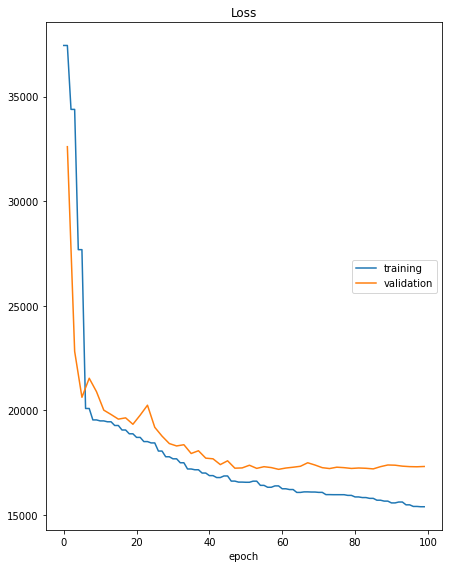

Loss
	training         	 (min: 15385.185, max: 37448.330, cur: 15385.185)
	validation       	 (min: 17174.311, max: 32606.410, cur: 17310.254)
New best validation loss: 17310.2539 with hyperparameters: {'lr_rate': 0.0006119110453614011, 'batch_size': 78, 'l1': 0.00046893325185287774, 'l2': 0.009564429613490721}
Optimal hyperparameters:
Learning rate: 0.000612
Batch size: 78
Lambda_1: 0.000469
Lmabda_2: 0.009564
Validation loss: 17310.2539


In [ ]:
# Bayesian Optimisation
# Dont run it

#!pip install livelossplot
from livelossplot import PlotLosses
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
beta = best_beta

def vae_train(lr_rate, batch_size, l1, l2):
    # create dataloaders with the specified batch_size
    batch_size = int(batch_size)
    dataloaders = {
        'train': torch.utils.data.DataLoader(train_, batch_size, shuffle=True),
        'validation': torch.utils.data.DataLoader(val_, batch_size, shuffle=False)
    }

    # Create model, optimizer and loss function
    model = VAE(INPUT_DIM, H_DIM, Z_DIM).to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=lr_rate)
    loss_fn = nn.MSELoss(reduction='sum')

    # Train the model
    liveloss = PlotLosses()
    x_reconstruct_ls = []

    for epoch in range(NUM_EPOCHS):
        logs = {}
        for phase in ["train", "validation"]:
            loss_lst = []
            if phase == "train":
                model.train()
            else:
                model.eval()
            loop = tqdm.tqdm(enumerate(dataloaders[phase]))
            for i, (x, _) in loop:
                # Forward pass
                x = x.to(DEVICE).view(x.shape[0], -1)
                x_reconstruct, mu, sigma = model(x)

                # Compute loss with Loss function
                reconstruction_loss = loss_fn(x_reconstruct, x)/len(x)
                kl_div = (-0.5*torch.sum(1 + torch.log(sigma.pow(2)) - mu.pow(2) - sigma.pow(2))*beta)/len(x)

                
                # Compute L1 & L2 regularization
                L1_regularization = torch.tensor(0., device=DEVICE)
                for param in model.parameters():
                  L1_regularization += torch.norm(param, 1)
                L1_regularization /= len(x)
                L2_regularization = torch.tensor(0., device=DEVICE)
                for param in model.parameters():
                  L2_regularization += torch.norm(param, 2)
                L2_regularization /= len(x)

                # Backpropagation
                loss = reconstruction_loss + kl_div + l1 * L1_regularization + l2 * L2_regularization
                loss_lst.append(loss.item())

                if phase == "train":
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                loop.set_postfix(loss=loss.item())

            prefix = ""
            if phase == "validation":
                prefix = "val_"

            logs[prefix + "loss"] = np.mean(loss_lst)

            liveloss.update(logs)
        liveloss.send()
    
    # Return the final validation loss as the optimization target
    return logs['val_loss']

# Define the search space for the hyperparameters
search_space = [(1e-5, 1e-3), (1e-6, 0.01), (1e-6, 0.01)]
search_space_batch_size = [(8, 123)] 

# Perform Bayesian optimization to find the optimal hyperparameters
n_calls = 15
best_val_loss = np.inf
for i in range(n_calls):
    # randomly sample hyperparameters from the search space
    lr_rate, l1, l2 = [np.random.uniform(low=low, high=high) for (low, high) in search_space]

    while True:
      batch_size = [np.random.uniform(low=low, high=high) for (low, high) in search_space_batch_size]
      batch_size = int(batch_size[0])
      if (size-2) % batch_size != 1:
        break
    
    # train the model with the sampled hyperparameters
    val_loss = vae_train(lr_rate, batch_size, l1, l2)
    
    # update the best validation loss and hyperparameters if a better solution is found
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_hyperparams = {'lr_rate': lr_rate, 'batch_size': batch_size, 'l1': l1, 'l2': l2}
        print(f"New best validation loss: {best_val_loss:.4f} with hyperparameters: {best_hyperparams}")
        
# Print the optimal hyperparameters and the corresponding validation loss
print("Optimal hyperparameters:")
print(f"Learning rate: {best_hyperparams['lr_rate']:.6f}")
print(f"Batch size: {best_hyperparams['batch_size']}")
print(f"Lambda_1: {best_hyperparams['l1']:.6f}")
print(f"Lmabda_2: {best_hyperparams['l2']:.6f}")
print(f"Validation loss: {best_val_loss:.4f}")



In [ ]:
# Save the model to a file
torch.save(model.state_dict(), "/content/gdrive/MyDrive/Y2S2/SP3172/VAE/vae_model.pth")

In [ ]:
# Load the saved model from a file
loaded_model = VAE(INPUT_DIM)
loaded_model.load_state_dict(torch.load("/content/gdrive/MyDrive/Y2S2/SP3172/VAE/vae_model.pth"))
loaded_model.eval()  # Set the model to evaluation mode

VAE(
  (input2hid1): Linear(in_features=1406281, out_features=1000, bias=True)
  (hid12hid2): Linear(in_features=1000, out_features=1000, bias=True)
  (hid22mu): Linear(in_features=1000, out_features=10, bias=True)
  (hid22sigma): Linear(in_features=1000, out_features=10, bias=True)
  (z2hid1): Linear(in_features=10, out_features=1000, bias=True)
  (hid12hid2d): Linear(in_features=1000, out_features=1000, bias=True)
  (hid22output): Linear(in_features=1000, out_features=1406281, bias=True)
  (bn1): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
  (leakyrelu): LeakyReLU(negative_slope=0.01)
)

In [ ]:
# Set the number of samples and features
model = loaded_model
num_samples = 1000
num_features = INPUT_DIM

# Generate random samples from the latent space
z_samples = torch.randn(num_samples, Z_DIM)

# Decode the samples to obtain the corresponding output
with torch.no_grad():
    x_samples = model.decode(z_samples)

# Compute the baseline output
baseline = torch.zeros(num_samples, num_features)
baseline_output = model.decode(torch.zeros(num_samples, Z_DIM))

# Compute the feature importance scores
importance_scores = x_samples - baseline_output

# Rank the features based on their importance scores
mean_scores = torch.mean(importance_scores, dim=0)
sorted_scores, sorted_indices = torch.sort(mean_scores, descending=True)

# Select the top few features as the most important ones
num_top_features = 200
top_indices = sorted_indices[:num_top_features]
print(len(sorted_indices))
top_features_name = []

# Print the top features and their weightage
df = train.iloc[:, :]
for idx in top_indices:
    a = int(idx)
    print(f"{df.columns[a]}: {mean_scores[idx]}")
    top_features_name.append(df.columns[a])


1406281
rs2969182_A_G: 0.12373869121074677
rs4681292_A_C: 0.12123221158981323
rs4266157_A_G: 0.11811298877000809
GSA-rs10746789_G_G: 0.11772499978542328
rs79403057_A_A: 0.11681210994720459
rs1974700_G_G: 0.11672060936689377
GSA-rs80156053_C_C: 0.11615107208490372
GSA-rs16904337_A_G: 0.11607635021209717
rs437976_G_G: 0.11520624905824661
GSA-rs72660622_G_G: 0.1152057871222496
rs35879229_A_A: 0.11449113488197327
GSA-rs187655030_A_A: 0.11442552506923676
rs11670714_C_C: 0.11369609087705612
GSA-rs75759060_A_A: 0.11367172002792358
rs10510860_A_A: 0.11366713792085648
rs973358_A_G: 0.11326982080936432
GSA-rs9305651_A_A: 0.11326635628938675
rs17332034_A_A: 0.11303345859050751
GSA-rs73069946_?_?: 0.11294989287853241
GSA-rs12926421_G_G: 0.11231985688209534
rs1999934_A_G: 0.1119130402803421
rs742920_A_C: 0.11184638738632202
rs471746_A_G: 0.11170845478773117
GSA-rs75954564_A_A: 0.1116042211651802
GSA-rs149165055_A_G: 0.1115981787443161
rs12830922_?_?: 0.1115490049123764
rs2279525_G_G: 0.111538283526

In [ ]:
print(top_indices)
print(len(top_indices))
top_indices = top_indices.numpy()
print(top_indices)

tensor([1184137,  289763, 1025206,  265360, 1108797,  918349, 1184127, 1264733,
         767975,  256089,  944625,  469354,  486553,  869459, 1141291, 1037687,
         708367,  311760, 1295386, 1335121,  467062,  185373,   49130,  572451,
        1184121,  522658, 1094041,  482090, 1064971,  726851, 1383807,  152111,
         431004,  970178,  782880, 1184146, 1201167,  967886,   93148,  964676,
         237285,  254046,  527232, 1184151, 1283461,  742971,  388583,  360465,
         732591, 1011328,  417902,  413037,  549908, 1295793,  332275,  757817,
          84235, 1184104,  834339,   83670,  840599,  642398,  504262,  631980,
         536907,  740411,  132561, 1295453,  560145,   23116,  441145,  222875,
          69414,  512562,  350328, 1089282,  870041, 1099375, 1295390,  463467,
         970251,  657757,  512582, 1199853, 1079457,  887244,  512552, 1068828,
         565618,  515671,  493972, 1261723,  609308, 1246090,  945007, 1199640,
        1305367,  202294, 1178140, 11412

In [ ]:
top_features_name_mod = []
for i in top_features_name:
  top_features_name_mod.append(i.split("_")[0])
print(top_features_name_mod)

df1 = df.copy()


['GSA-rs188657828', 'rs200758108', 'rs2284291', 'rs3757329', 'rs741050', 'chr6:29531253', 'rs12417911', 'rs4246558', 'GSA-rs117587043', 'GSA-rs7962117']


(114, 2)
(114, 10)


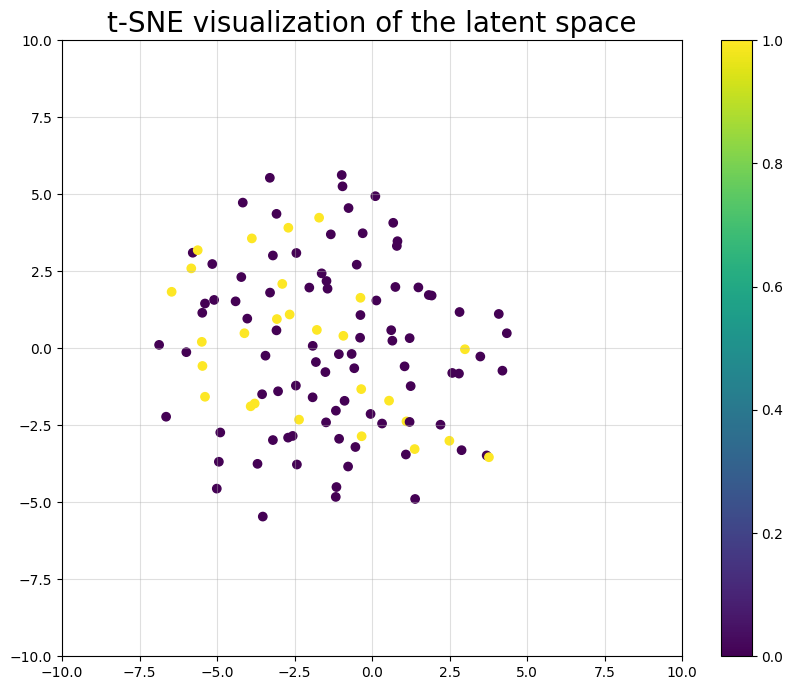

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

z = []
y = []

# Generate the latent vectors for each sample
with torch.no_grad():
    for x, label in dataloaders["train"]:
        x = x.to(DEVICE)
        _, mu, _ = model(x)
        z.append(mu.cpu().detach().numpy())
        y.append(label.numpy())

z = np.concatenate(z, axis=0)
y_ = np.concatenate(y, axis=0)
print(y_.shape)
print(z.shape)


# Compare the values in the first and second columns of each row
bool_arr = y_[:, 0] > y_[:, 1]

# Convert the boolean values to 0s and 1s
int_arr = bool_arr.astype(int)

# Reshape the 1D array into a column vector
int_arr = int_arr.reshape((-1, 1))
#print(int_arr)

# Reduce the dimensionality of the latent vectors using t-SNE
z_embedded = TSNE(n_components=2).fit_transform(z)

# Plot the reduced latent vectors
plt.figure(figsize=(10, 8))
plt.scatter(z_embedded[:, 0], z_embedded[:, 1], c=int_arr, cmap="viridis")
# adjust the length of the x-axis and y-axis
plt.xlim([-10, 10])
plt.ylim([-10, 10])
plt.colorbar()
plt.title("t-SNE visualization of the latent space", fontsize = 20)
plt.grid(alpha = 0.4)
#plt.savefig("/content/gdrive/MyDrive/Y2S2/SP3172/VAE/latent_space_6.png", dpi = 600)

plt.show()


(114, 2)
(114, 10)


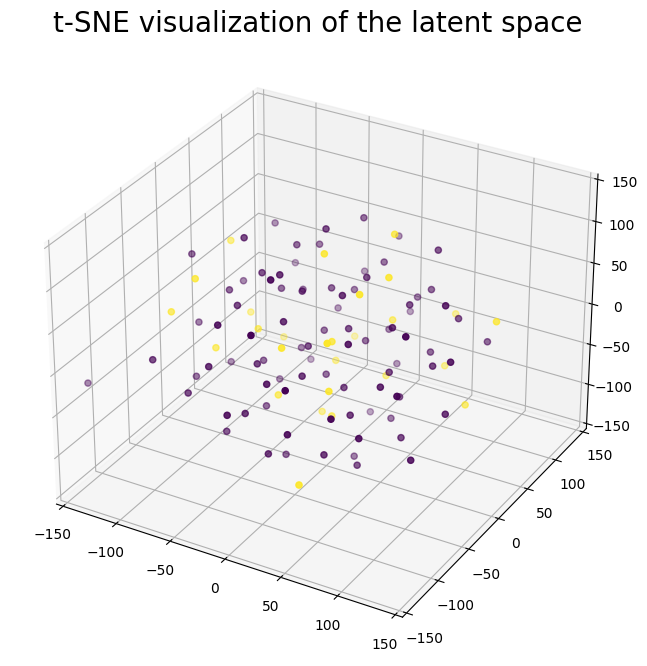

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE

z = []
y = []

# Generate the latent vectors for each sample
with torch.no_grad():
    for x, label in dataloaders["train"]:
        x = x.to(DEVICE)
        _, mu, _ = model(x)
        z.append(mu.cpu().detach().numpy())
        y.append(label.numpy())

z = np.concatenate(z, axis=0)
y_ = np.concatenate(y, axis=0)
print(y_.shape)
print(z.shape)


# Compare the values in the first and second columns of each row
bool_arr = y_[:, 0] > y_[:, 1]

# Convert the boolean values to 0s and 1s
int_arr = bool_arr.astype(int)

# Reshape the 1D array into a column vector
int_arr = int_arr.ravel()

#print(int_arr)

# Reduce the dimensionality of the latent vectors using t-SNE
z_embedded = TSNE(n_components=3).fit_transform(z)

# Plot the reduced latent vectors in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(z_embedded[:, 0], z_embedded[:, 1], z_embedded[:, 2], c=int_arr, cmap="viridis")
# adjust the length of the x-axis, y-axis and z-axis
ax.set_xlim([-150, 150])
ax.set_ylim([-150, 150])
ax.set_zlim([-150, 150])
#plt.colorbar()
ax.set_title("t-SNE visualization of the latent space", fontsize=20)
plt.grid(alpha=0.4)
#plt.savefig("/content/gdrive/MyDrive/Y2S2/SP3172/VAE/latent_space_5.png", dpi=600)

plt.show()


In [ ]:
# Generation of synthetic data
model = loaded_model

def generate_synthetic_data(model, n_samples):
    # Generate n_samples random latent vectors
    z = torch.randn(n_samples, Z_DIM).to(DEVICE)
    
    # Decode the latent vectors to get synthetic data
    synthetic_data = model.decode(z)
    
    # Move the synthetic data to CPU and convert to numpy array
    synthetic_data = synthetic_data.detach().cpu().numpy()
    
    return synthetic_data

# Generate 2500 synthetic samples
synthetic_data = generate_synthetic_data(model, 1000)
print(synthetic_data)

# Convert synthetic data to pandas dataframe and export to CSV
df_synthetic = pd.DataFrame(synthetic_data, columns=train.columns[2:])
#df_synthetic.to_csv('/content/gdrive/MyDrive/Y2S2/SP3172/Datasets/synthetic_data_1.csv', index=False)
#df_synthetic.to_csv('synthetic_data.csv', index=False)
df_synthetic


[[0.22717902 0.23760504 0.13440862 ... 0.819974   0.1231655  0.86136466]
 [0.19040412 0.5155182  0.05927811 ... 0.8032845  0.15432724 0.85153973]
 [0.5020153  0.6130697  0.14732142 ... 0.82461786 0.14097874 0.8728248 ]
 ...
 [0.3487455  0.48677233 0.1246021  ... 0.7760534  0.1364777  0.838206  ]
 [0.38690528 0.47101554 0.08152879 ... 0.87815225 0.0829239  0.8814324 ]
 [0.28939185 0.3798999  0.06928834 ... 0.87719893 0.08153691 0.9220584 ]]


,EV = 2.98282,EV = 1.0356,Age,Age at treatment,Total number of cycles,Cumulative Dose,Weight,Stage of Diagnosis_I,Stage of Diagnosis_II,Stage of Diagnosis_III,...,rs7067441_?_?,rs7067441_C_C,rs7067441_C_G,rs7067384_A_A,rs7067384_A_G,rs16980574_?_?,rs16980574_C_C,rs16980574_G_G,rs9786255_A_A,rs9786255_G_G
0,0.227179,0.237605,0.134409,0.128530,0.234245,0.244632,0.433161,0.123782,0.535328,0.323508,...,0.194232,0.800349,0.145881,0.865712,0.127831,0.153920,0.114452,0.819974,0.123165,0.861365
1,0.190404,0.515518,0.059278,0.077403,0.301971,0.262015,0.582129,0.147120,0.484523,0.363408,...,0.155486,0.820606,0.143861,0.845460,0.153733,0.171058,0.161512,0.803285,0.154327,0.851540
2,0.502015,0.613070,0.147321,0.219934,0.295658,0.233908,0.362644,0.176045,0.515126,0.352102,...,0.087143,0.864983,0.121307,0.897345,0.109765,0.143751,0.140261,0.824618,0.140979,0.872825
3,0.209458,0.611411,0.112109,0.140302,0.253582,0.182848,0.650958,0.192616,0.480457,0.341514,...,0.126901,0.855674,0.145116,0.838385,0.174585,0.206136,0.215075,0.733493,0.196298,0.825261
4,0.365259,0.604814,0.059872,0.094216,0.508770,0.494734,0.515580,0.157194,0.564204,0.268394,...,0.065844,0.933330,0.096612,0.893907,0.096661,0.118236,0.108650,0.869850,0.090119,0.883424
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.460449,0.302835,0.314111,0.403988,0.249251,0.243695,0.284009,0.157874,0.602299,0.403976,...,0.112077,0.790208,0.194655,0.848427,0.118169,0.174131,0.143603,0.809798,0.128790,0.837091
996,0.572356,0.463026,0.318339,0.356152,0.350599,0.318173,0.283634,0.275627,0.460860,0.456748,...,0.231851,0.702634,0.264087,0.777812,0.209697,0.234733,0.220622,0.756340,0.229517,0.784618
997,0.348745,0.486772,0.124602,0.153368,0.375943,0.359353,0.562652,0.131633,0.585750,0.294605,...,0.110011,0.855012,0.153107,0.857302,0.125751,0.198347,0.127444,0.776053,0.136478,0.838206
998,0.386905,0.471016,0.081529,0.172180,0.243149,0.225460,0.293447,0.090766,0.565519,0.384645,...,0.075963,0.858673,0.107212,0.923566,0.081063,0.114060,0.084834,0.878152,0.082924,0.881432


In [ ]:
df_synthetic.to_csv('/content/gdrive/MyDrive/Y2S2/SP3172/Datasets/synthetic_data_preselected.csv', index=False)

In [ ]:
sorted_top_indices = sorted(top_indices)
sorted_top_indices


[14327,
 23116,
 32970,
 32975,
 49130,
 52344,
 69414,
 83670,
 84159,
 84235,
 91570,
 93148,
 96544,
 96589,
 97571,
 97574,
 124925,
 132561,
 142640,
 152111,
 153634,
 165836,
 170575,
 185373,
 202294,
 204614,
 211389,
 222875,
 237285,
 254046,
 256082,
 256089,
 265360,
 265928,
 289763,
 311760,
 312719,
 312748,
 319840,
 331003,
 332275,
 348558,
 350328,
 351019,
 360465,
 388583,
 399851,
 413037,
 417902,
 428239,
 431004,
 433674,
 441145,
 447594,
 447683,
 463467,
 467062,
 469354,
 469374,
 476595,
 482090,
 486553,
 493972,
 496818,
 500093,
 504262,
 512552,
 512562,
 512582,
 512611,
 515671,
 515894,
 515941,
 522526,
 522640,
 522658,
 523836,
 527232,
 536907,
 536926,
 537403,
 538355,
 549908,
 560145,
 560316,
 565618,
 567377,
 572451,
 609308,
 615818,
 631980,
 632444,
 642398,
 644226,
 657757,
 657791,
 658023,
 675290,
 687452,
 698328,
 708367,
 719651,
 726851,
 732591,
 740411,
 742971,
 752540,
 756311,
 757817,
 763906,
 767975,
 782880,
 793744,

In [ ]:
top_features_name = []

# Print the top features and their weightage
df = train.iloc[:, :]
for idx in sorted_top_indices:
    a = int(idx)
    #print(f"{df.columns[a]}: {mean_scores[idx]}")
    top_features_name.append(df.columns[a])

In [ ]:
print(len(top_features_name))
print(top_features_name)


200
['rs12028875_G_G', 'GSA-rs2228553_G_G', 'rs4926684_G_G', 'rs12094871_?_?', 'rs12409930_A_G', 'rs12759704_G_G', 'rs2486824_G_G', 'rs12735014_G_G', 'GSA-rs77193263_A_G', 'GSA-rs61819584_G_G', 'GSA-rs12073615_C_C', 'GSA-rs3845524_G_G', 'rs79318050_A_A', 'rs2584315_G_G', 'GSA-rs34631151_A_G', 'rs16846244_A_G', 'rs4128553_G_G', 'rs17332034_A_A', 'rs55714450_A_A', 'GSA-rs117060509_A_A', 'rs11126625_G_G', 'rs6752687_G_G', 'rs6758186_?_?', 'GSA-rs59462638_?_?', 'GSA-rs79592426_A_G', 'rs72947228_A_A', 'rs12457_A_G', 'rs12694997_G_G', 'GSA-rs74284295_A_G', 'rs4681727_C_C', 'rs75775536_A_G', 'rs10510860_A_A', 'rs4266157_A_G', 'GSA-rs6548685_A_C', 'rs4681292_A_C', 'GSA-rs149165055_A_G', 'rs9854771_A_G', 'GSA-rs116327056_A_A', 'rs118005095_?_?', 'GSA-rs76499745_G_G', 'rs2279525_G_G', 'rs6852374_G_G', 'rs17740078_A_A', 'rs8180319_G_G', 'rs72874818_C_C', 'GSA-rs2708233_G_G', 'GSA-rs17071761_G_G', 'GSA-rs77023695_?_?', 'GSA-rs2972919_A_G', 'rs77441020_G_G', 'rs35879229_A_A', 'GSA-rs116202687_A_G',

In [ ]:
# select the desired columns using .loc[]
df_synthetic_selected = df_synthetic.loc[:, top_features_name]

# print the resulting dataframe
print(df_synthetic_selected)

     rs12028875_G_G  GSA-rs2228553_G_G  rs4926684_G_G  rs12094871_?_?  \
0          0.649464           0.870364       0.370448        0.109584   
1          0.657131           0.852231       0.374800        0.128526   
2          0.429048           0.854388       0.426603        0.112818   
3          0.539565           0.824602       0.469429        0.162244   
4          0.525431           0.892569       0.581255        0.091986   
..              ...                ...            ...             ...   
995        0.422450           0.834257       0.451248        0.115190   
996        0.497422           0.735725       0.428067        0.212593   
997        0.453774           0.858769       0.513341        0.121337   
998        0.407804           0.890774       0.383350        0.068329   
999        0.587509           0.932882       0.561197        0.057132   

     rs12409930_A_G  rs12759704_G_G  rs2486824_G_G  rs12735014_G_G  \
0          0.596976        0.728204       0.161262   

In [ ]:
df_synthetic_selected.to_csv('/content/gdrive/MyDrive/Y2S2/SP3172/Datasets/synthetic_data_selected.csv', index=False)

In [ ]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a VAE on the training data
vae = train_vae(X_train, ...)

# Map the training and test data to the learned low-dimensional space
Z_train = vae.encode(X_train)
Z_test = vae.encode(X_test)

# Train a regression or classification model on the low-dimensional representations of the training data
model = train_model(Z_train, y_train, ...)

# Use the trained model to predict the target variable for the low-dimensional representations of the test data
y_pred = model.predict(Z_test)

# Map the predicted target variable back to the original high-dimensional space
X_pred = vae.decode(Z_test, y_pred)

In [ ]:
import pandas as pd
drive.mount('/content/gdrive', force_remount=True)

# create example dataframe
df = pd.read_csv('/content/gdrive/MyDrive/Y2S2/SP3172/Datasets/synthetic_data_preconverted.csv')


# loop through each column and find columns with same prefix
for col in df.columns:
    prefix = col.split('_')[0]
    same_prefix_cols = [c for c in df.columns if c.startswith(prefix)]
    # get maximum value for each row for columns with same prefix
    max_val = df[same_prefix_cols].max(axis=1)
    # set all values in same_prefix_cols to 0 except max_val which is set to 1
    df.loc[:, same_prefix_cols] = (df[same_prefix_cols] == max_val[:,None]).astype(int)




df.to_csv("/content/gdrive/MyDrive/Y2S2/SP3172/Datasets/synthetic_data_converted.csv", index = False)


# display the resulting dataframe
df





Mounted at /content/gdrive


<ipython-input-8-797374bb0af9>:15: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df.loc[:, same_prefix_cols] = (df[same_prefix_cols] == max_val[:,None]).astype(int)
<ipython-input-8-797374bb0af9>:15: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df.loc[:, same_prefix_cols] = (df[same_prefix_cols] == max_val[:,None]).astype(int)
<ipython-input-8-797374bb0af9>:15: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df.loc[:, same_prefix_cols] = (df[same_prefix_cols] == max_val[:,None]).astype(int)
<ipython-input-8-797374bb0af9>:15: FutureWarning: Support for multi-dimensional indexing (e

,rs12028875_?_?,rs12028875_A_A,rs12028875_A_G,rs12028875_G_G,GSA-rs2228553_A_G,GSA-rs2228553_G_G,rs4926684_A_A,rs4926684_A_G,rs4926684_G_G,rs12094871_?_?,...,rs73239864_A_A,rs73239864_A_C,rs73239864_C_C,rs62608294_A_A,rs62608294_A_C,rs62608294_C_C,rs147876553_?_?,rs147876553_C_C,rs147876553_C_G,rs147876553_G_G
0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
996,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
997,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
998,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [ ]:
df.to_csv("test.csv")

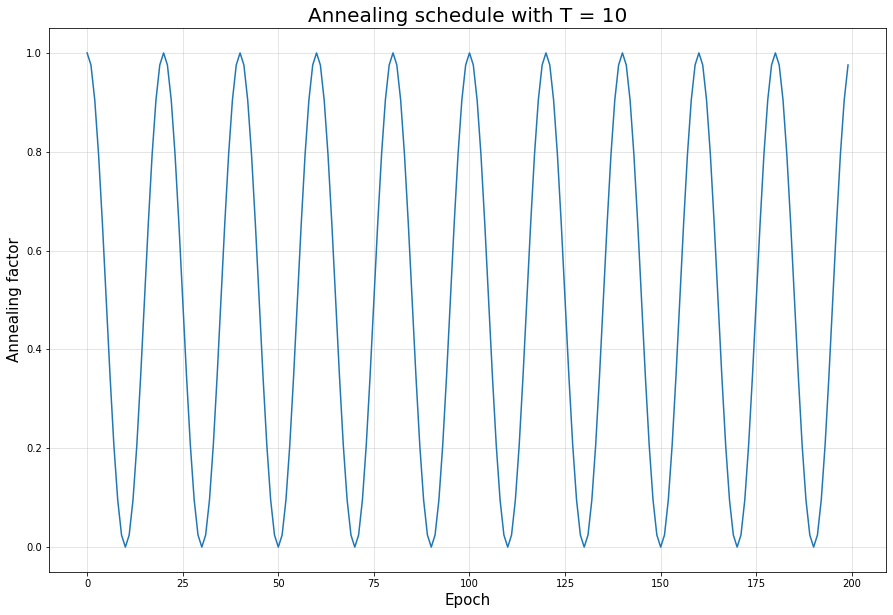

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def anneal_function(epoch, T=10):
    return (1 + np.cos(np.pi * epoch / T)) / 2

T =10
x = np.arange(0, 20*T)
y = [anneal_function(i, T) for i in x]

plt.figure(figsize =  (15, 10))
plt.plot(x, y)
plt.xlabel('Epoch', fontsize = 15)
plt.ylabel('Annealing factor', fontsize = 15)
plt.title(f'Annealing schedule with T = {T}', fontsize = 20)
plt.grid(alpha = 0.4)
plt.savefig("cyclical_annealing.png", dpi = 600)
plt.show()
